In [1]:
import torch
from torch import optim
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from einops import repeat

from utils.data import read_domain_ids_per_chain_from_txt
from common.res_infor import *
from utils.dataset import *
from diffusion_model.sequence_diffusion_model import *

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 100
LEARNING_RATE = 1e-3

In [3]:
# Load data
train_pdbs, train_pdb_chains = read_domain_ids_per_chain_from_txt('./data/train_domains.txt')
test_pdbs, test_pdb_chains = read_domain_ids_per_chain_from_txt('./data/test_domains.txt')
train_loader = BackboneCoordsDataLoader(train_pdb_chains, "./data/train_backbone_coords_20.npy", "./data/train_data_res_20.npy",seq_length=20, batch_size=128, shuffle=True)
test_loader = BackboneCoordsDataLoader(test_pdb_chains, './data/test_backbone_coords_20.npy', './data/test_data_res_20.npy', seq_length=20, batch_size=128, shuffle=True)

# Print some Sequence data

In [4]:
# print some Sequence data
def tensor_to_string(tensor, label_res_dict):
    sequences = []
    for i in range(tensor.size(0)):
        sequence = "".join([label_res_dict[residue.item()] if residue.item() != 21 else '*' for residue in tensor[i]])
        sequences.append(sequence)
    return sequences
    
for batch_idx, (pdb_id, res, data) in enumerate(train_loader):
    res = res.squeeze()
    sequences = tensor_to_string(res, label_res_dict)
    print(pdb_id[:5])
    print(sequences[:5])
    break

('2gsiA', '3oa8A', '1y14D', '4lwoE', '3judA')
['DIVLTQSPASLAVSLGQPAT', 'ANPGFLNVDRGEVLWSEPRG', 'MFFIKDLSLNITLPSFFGPR', 'ESYSDLAVHRLMLEDAQRMS', 'MALVFVYGTLKRGQPNHRVL']


# Visualization of the forward process

In [5]:
# Visualization of the forward process
diffusion = SequenceDiffusion()

pdb_id, res, _ = next(iter(train_loader))
pdb_1 = pdb_id[0]
res_1 = res[0].reshape(1, -1)
print(pdb_1[:4] + " " + pdb_1[-1])

for t in range(0, 101, 10):
    t = torch.tensor([t])
    x_t, _, _= diffusion.seq_q_sample(res_1, t,)
    sequences = tensor_to_string(x_t, label_res_dict)
    print(f"t = {t.item()}:", sequences)

2ve3 B
t = 0: ['SLPIPPGDFGLPWLGETLNF']
t = 10: ['SLPIPP*D*GLPWLGETLNF']
t = 20: ['SLPI*PGD*GLPWLGE*LN*']
t = 30: ['******GD***PW*G*TLNF']
t = 40: ['*LPIP*GDFGL**LGET*NF']
t = 50: ['S****PGDFG***L*****F']
t = 60: ['SLPI***D*GLPWLG*T**F']
t = 70: ['S***PPG**G**W*******']
t = 80: ['****P****G*P**G*TLN*']
t = 90: ['********F****L******']
t = 100: ['********************']


# Model training

In [6]:
diffusion = SequenceDiffusion(device=DEVICE)
model = SequenceModel().to(DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr = 1e-3)

In [7]:
loss_history = []
for epoch in range(EPOCH):    
    model.train()
    train_loss = 0
    for batch_idx, (pdb, res_label, atom_coords) in enumerate(tqdm(train_loader, leave=False)):
        # Data preparation
        x_0 = res_label.to(DEVICE).squeeze(-1)
        x_0 = x_0.to(torch.float32)
    
        n_coords = atom_coords[:, :, 0]
        ca_coords = atom_coords[:, :, 1]
        c_coords = atom_coords[:, :, 2]

        pair_repr = torch.cdist(ca_coords, ca_coords, p=2)
        rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
        
        # Foward Diffusion
        batch_size = atom_coords.shape[0]
        t, pt = diffusion.sample_timesteps(batch_size = batch_size, device=DEVICE)

        x_t, x_0_ignore, mask = diffusion.seq_q_sample(x_0, t)
      
        # Backward Diffusion
        x_0_hat_logits = model(x_t, pair_repr.to(DEVICE, torch.float32), rotations.to(DEVICE,torch.float32), translations.to(DEVICE, torch.float32))

        # Custom loss function
        cross_entropy_loss = F.cross_entropy(x_0_hat_logits.transpose(1, 2), 
                                             x_0_ignore.reshape(batch_size, 20).to(torch.int64), 
                                             ignore_index = -1, reduction='none').mean(1)
        vb_loss = cross_entropy_loss / t
        vb_loss = vb_loss / pt
        vb_loss = vb_loss / (math.log(2) * x_0.shape[1:].numel())

        loss = vb_loss.mean()

        optimizer.zero_grad()
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    avg_loss = train_loss / len(train_loader.dataset)
    loss_history.append(avg_loss)
    print('====> Epoch: {} Average loss: {:.10f}'.format(epoch, avg_loss))

====> Epoch: 0 Average loss: 0.0015541926


====> Epoch: 1 Average loss: 0.0015003494


====> Epoch: 2 Average loss: 0.0014724689


====> Epoch: 3 Average loss: 0.0014465214


====> Epoch: 4 Average loss: 0.0014285617


====> Epoch: 5 Average loss: 0.0014172698


====> Epoch: 6 Average loss: 0.0014050568


====> Epoch: 7 Average loss: 0.0013972814


====> Epoch: 8 Average loss: 0.0013962481


====> Epoch: 9 Average loss: 0.0013876278


====> Epoch: 10 Average loss: 0.0013853546


====> Epoch: 11 Average loss: 0.0013764017


====> Epoch: 12 Average loss: 0.0013675245


====> Epoch: 13 Average loss: 0.0013675046


====> Epoch: 14 Average loss: 0.0013643874


====> Epoch: 15 Average loss: 0.0013641875


====> Epoch: 16 Average loss: 0.0013578685


====> Epoch: 17 Average loss: 0.0013529881


====> Epoch: 18 Average loss: 0.0013521154


====> Epoch: 19 Average loss: 0.0013515438


====> Epoch: 20 Average loss: 0.0013489126


====> Epoch: 21 Average loss: 0.0013441392


====> Epoch: 22 Average loss: 0.0013454397


====> Epoch: 23 Average loss: 0.0013429655


====> Epoch: 24 Average loss: 0.0013378412


====> Epoch: 25 Average loss: 0.0013405368


====> Epoch: 26 Average loss: 0.0013368692


====> Epoch: 27 Average loss: 0.0013352687


====> Epoch: 28 Average loss: 0.0013394124


====> Epoch: 29 Average loss: 0.0013341957


====> Epoch: 30 Average loss: 0.0013272736


====> Epoch: 31 Average loss: 0.0013257457


====> Epoch: 32 Average loss: 0.0013225338


====> Epoch: 33 Average loss: 0.0013204465


====> Epoch: 34 Average loss: 0.0013278008


====> Epoch: 35 Average loss: 0.0013218679


====> Epoch: 36 Average loss: 0.0013259330


====> Epoch: 37 Average loss: 0.0013197358


====> Epoch: 38 Average loss: 0.0013177887


====> Epoch: 39 Average loss: 0.0013156478


====> Epoch: 40 Average loss: 0.0013161496


====> Epoch: 41 Average loss: 0.0013143637


====> Epoch: 42 Average loss: 0.0013140511


====> Epoch: 43 Average loss: 0.0013110145


====> Epoch: 44 Average loss: 0.0013115926


====> Epoch: 45 Average loss: 0.0013128359


====> Epoch: 46 Average loss: 0.0013062740


====> Epoch: 47 Average loss: 0.0013093622


====> Epoch: 48 Average loss: 0.0013094194


====> Epoch: 49 Average loss: 0.0013102111


====> Epoch: 50 Average loss: 0.0013090218


====> Epoch: 51 Average loss: 0.0013078079


====> Epoch: 52 Average loss: 0.0013063439


====> Epoch: 53 Average loss: 0.0013038177


====> Epoch: 54 Average loss: 0.0013085020


====> Epoch: 55 Average loss: 0.0013034606


====> Epoch: 56 Average loss: 0.0012996672


====> Epoch: 57 Average loss: 0.0013008396


====> Epoch: 58 Average loss: 0.0013071336


====> Epoch: 59 Average loss: 0.0012989402


====> Epoch: 60 Average loss: 0.0012996618


====> Epoch: 61 Average loss: 0.0013005040


====> Epoch: 62 Average loss: 0.0012947134


====> Epoch: 63 Average loss: 0.0013004032


====> Epoch: 64 Average loss: 0.0012962868


====> Epoch: 65 Average loss: 0.0012968459


====> Epoch: 66 Average loss: 0.0012968707


====> Epoch: 67 Average loss: 0.0012997390


====> Epoch: 68 Average loss: 0.0012874147


====> Epoch: 69 Average loss: 0.0012931648


====> Epoch: 70 Average loss: 0.0012872765


====> Epoch: 71 Average loss: 0.0012977688


====> Epoch: 72 Average loss: 0.0012926666


====> Epoch: 73 Average loss: 0.0012878975


====> Epoch: 74 Average loss: 0.0012989259


====> Epoch: 75 Average loss: 0.0012939479


====> Epoch: 76 Average loss: 0.0012995550


====> Epoch: 77 Average loss: 0.0012938128


====> Epoch: 78 Average loss: 0.0012913351


====> Epoch: 79 Average loss: 0.0012902894


====> Epoch: 80 Average loss: 0.0012926970


====> Epoch: 81 Average loss: 0.0012890471


====> Epoch: 82 Average loss: 0.0012904550


====> Epoch: 83 Average loss: 0.0012876328


====> Epoch: 84 Average loss: 0.0012893043


====> Epoch: 85 Average loss: 0.0012906352


====> Epoch: 86 Average loss: 0.0012837132


====> Epoch: 87 Average loss: 0.0012880441


====> Epoch: 88 Average loss: 0.0012874502


====> Epoch: 89 Average loss: 0.0012850766


====> Epoch: 90 Average loss: 0.0012890336


====> Epoch: 91 Average loss: 0.0012857958


====> Epoch: 92 Average loss: 0.0012889988


====> Epoch: 93 Average loss: 0.0012877674


====> Epoch: 94 Average loss: 0.0012836796


====> Epoch: 95 Average loss: 0.0012810938


====> Epoch: 96 Average loss: 0.0012877015


====> Epoch: 97 Average loss: 0.0012845707


====> Epoch: 98 Average loss: 0.0012862899


====> Epoch: 99 Average loss: 0.0012818797


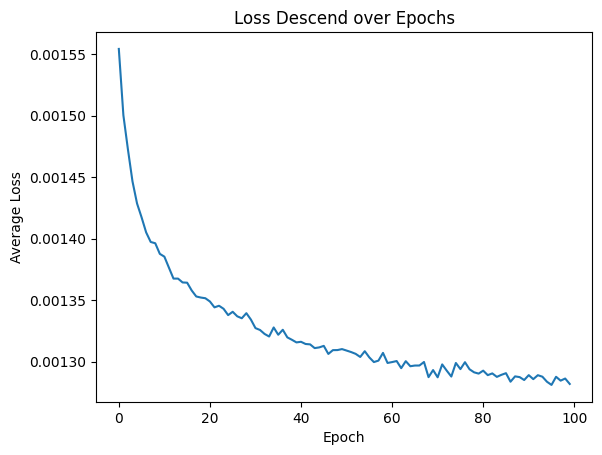

In [8]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Descend over Epochs')
plt.show()

In [9]:
# save the model
torch.save(model.state_dict(), './trained_models/sequence_model_pairwise.pt')

In [17]:
# sample
model.eval()
batch_size = 1
seq_length = 20

# groud truth sequence
pdb_id, res, atom_coords = next(iter(test_loader))
atom_coords = atom_coords.to(torch.float32)
n_coords = atom_coords[:, :, 0]
ca_coords = atom_coords[:, :, 1]
c_coords = atom_coords[:, :, 2]
rotations, translations = rigidFrom3Points(n_coords, ca_coords, c_coords)
pair_repr = torch.cdist(ca_coords, ca_coords, p=2).to(DEVICE)

res = res.squeeze()
sequences = tensor_to_string(res, label_res_dict)
print("PDB ID:",pdb_id[0])

# prepare data, only generate one sequence corresponding to ground truth backbone structure
x_t = torch.ones(batch_size, seq_length, device=DEVICE, dtype=torch.int64) * 21

rotation = rotations[0].unsqueeze(0)
translation = translations[0].unsqueeze(0)
rotation = rotation.to(DEVICE)
translation = translation.to(DEVICE)
pair_repr = pair_repr[0].unsqueeze(0)

#rotations = repeat(torch.eye(3), 'r1 r2 -> b n r1 r2', b = batch_size, n = seq_length)
#translations  = torch.randn(batch_size, seq_length, 3, device=DEVICE)
unmasked = torch.zeros_like(x_t, device=DEVICE).bool()
sample_steps = list(range(1, 100+1))

# sample
for t in reversed(sample_steps):
  t = torch.full((batch_size,), t, device=DEVICE, dtype=torch.int64)
  # where to unmask
  t_mask = t.reshape(batch_size, 1)
  t_mask = t_mask.expand(batch_size, 20)

  changes = torch.rand_like(x_t.float()) < 1 / t_mask.float()
  changes = torch.bitwise_xor(changes, torch.bitwise_and(changes, unmasked))
  
  # update mask with changes
  unmasked = torch.bitwise_or(unmasked, changes)
  x_0_logits = model(x_t.float(), pair_repr, rotation, translation)
  index = torch.argmax(x_0_logits,dim=2)

  x_t.long()[changes] = index.long()[changes]

  sequence = tensor_to_string(x_t, label_res_dict)
  print(print(f"t = {t.item()}:", sequence))

print("ground truth sequence is:", sequences[0])

PDB ID: 1hxvA
t = 100: ['********************']
None
t = 99: ['********************']
None
t = 98: ['********************']
None
t = 97: ['********************']
None
t = 96: ['*************L******']
None
t = 95: ['*************L******']
None
t = 94: ['********K****L******']
None
t = 93: ['********K****L******']
None
t = 92: ['********K****L******']
None
t = 91: ['********K****L******']
None
t = 90: ['********K****L******']
None
t = 89: ['********K****L******']
None
t = 88: ['********K****L******']
None
t = 87: ['********K****L******']
None
t = 86: ['********K****L******']
None
t = 85: ['********K****L******']
None
t = 84: ['********K****L******']
None
t = 83: ['********K****L******']
None
t = 82: ['********K****L******']
None
t = 81: ['********K****L****S*']
None
t = 80: ['********K****L****S*']
None
t = 79: ['********K****L****S*']
None
t = 78: ['********K****L****S*']
None
t = 77: ['********K****L**N*S*']
None
t = 76: ['********K****L**N*S*']
None
t = 75: ['********K****L**N*S*']
No